## To do:
* monthly mean vs daily
* detrend data compare
* remove offset from climate projections
* check resolution


In [1]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run

In [ ]:
# Function to run model per gridcell



In [2]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])


In [4]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [7]:
# Fill LAI with zeros were Na :D (wrong)
lai_data = lai_data.fillna(0)

In [18]:
# Best paramters from calibration
cs = 420 
alpha = 8 
gamma = 0.2 
beta = 0.8
cm = 1.5 
et_weight = (0.75, 0.25)

In [8]:
# Run model for all gridcells 1:30 min for one cell... there are 484 cells


# Create empty arrays to store the output data
snow = np.zeros_like(P_data)
soil_moisture = np.zeros_like(P_data)
evapotranspiration = np.zeros_like(P_data)

# Iteerate through gridcels
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        
        if np.isnan(lai_data[:, lat, lon]).any():
            print("Na found in gridcell", lat, lon)
            continue

        R_data_grid = R_data[:, lat, lon]
        P_data_grid = P_data[:, lat, lon]
        T_data_grid = T_data[:, lat, lon]
        lai_data_grid = lai_data[:, lat, lon]

        # Run Model for daily values
        daily_output = run.time_evolution(P_data_grid, R_data_grid, T_data_grid, lai_data_grid, cs, alpha,
        gamma, beta, cm, et_weight)

        snow[:, lat, lon] = daily_output['snow'].values
        soil_moisture[:, lat, lon] = daily_output['calculated_soil_moisture'].values
        evapotranspiration[:, lat, lon] = daily_output['evapotranspiration'].values
        break
    break

In [9]:
# Convert arrays to xarrays with corresponding latitudes and longitudes
snow_xr = xr.DataArray(snow, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
soil_moisture_xr = xr.DataArray(soil_moisture, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
evapotranspiration_xr = xr.DataArray(evapotranspiration, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})

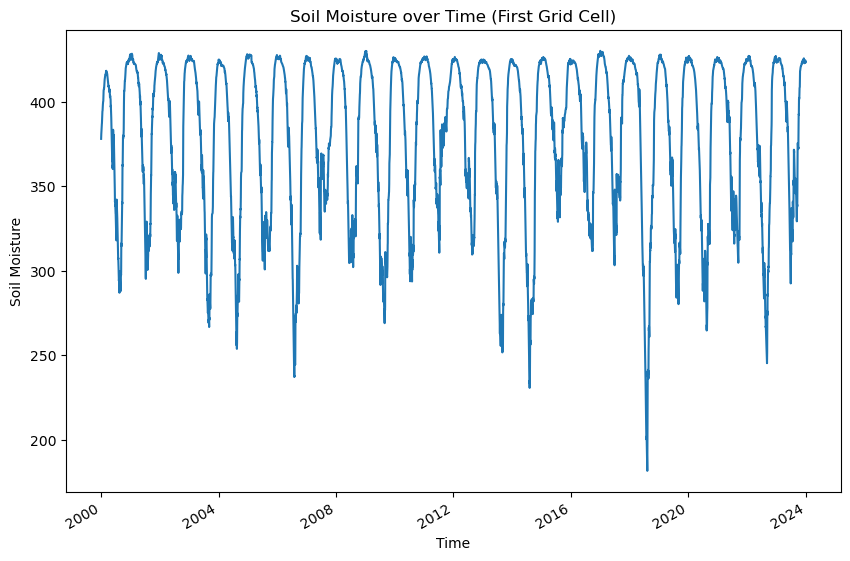

In [15]:
plt.figure(figsize=(10, 6))
soil_moisture_xr.isel(lat=0, lon=0).plot(x='time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture over Time (First Grid Cell)')
plt.show()

## Run model on monthly data

In [ ]:
# Sort lai data
lai_data_sort = lai_data.sortby('time')

# Calculate monthly means
P_monthly_mean = P_data.resample(time='1M').mean(dim='time')
R_monthly_mean = R_data.resample(time='1M').mean(dim='time')
T_monthly_mean = T_data.resample(time='1M').mean(dim='time')
lai_monthly_mean = lai_data_sort.resample(time='1M').mean(dim='time')

In [17]:
# Run model for all gridcells 1:30 min for one cell... there are 484 cells


# Create empty arrays to store the output data
snow_monthly = np.zeros_like(P_data)
soil_moisture_monthly = np.zeros_like(P_data)
evapotranspiration_monthly = np.zeros_like(P_data)

# Iteerate through gridcels
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        
        if np.isnan(lai_data[:, lat, lon]).any():
            print("Na found in gridcell", lat, lon)
            continue

        R_data_grid = R_data[:, lat, lon]
        P_data_grid = P_data[:, lat, lon]
        T_data_grid = T_data[:, lat, lon]
        lai_data_grid = lai_data[:, lat, lon]

        # Run Model for daily values
        daily_output = run.time_evolution(P_data_grid, R_data_grid, T_data_grid, lai_data_grid, cs, alpha,
        gamma, beta, cm, et_weight)

        snow_monthly[:, lat, lon] = daily_output['snow'].values
        soil_moisture_monthly[:, lat, lon] = daily_output['calculated_soil_moisture'].values
        evapotranspiration_monthly[:, lat, lon] = daily_output['evapotranspiration'].values
        break
    break

<xarray.DataArray 'tp' (time: 288, lat: 22, lon: 22)>
array([[[0.00183084, 0.00188541, 0.00196288, ..., 0.00144439,
         0.00147113, 0.00143617],
        [0.00167239, 0.00169578, 0.00175769, ..., 0.00156766,
         0.00165316, 0.00175533],
        [0.00157306, 0.00161059, 0.00169856, ..., 0.00164755,
         0.00174905, 0.00189106],
        ...,
        [0.00101078, 0.00128344, 0.00152399, ..., 0.00039893,
         0.0006305 , 0.00078446],
        [0.00084367, 0.00103315, 0.00118853, ..., 0.00087777,
         0.00106259, 0.00118087],
        [0.00051242, 0.00064788, 0.0006374 , ..., 0.00147008,
         0.0012935 , 0.00124396]],

       [[0.00292911, 0.00308594, 0.00319858, ..., 0.00176141,
         0.00164015, 0.00151298],
        [0.00290133, 0.00287954, 0.00283279, ..., 0.00202592,
         0.00193694, 0.00188177],
        [0.00280105, 0.00273454, 0.00270278, ..., 0.00219186,
         0.00219943, 0.00220977],
...
        [0.00437036, 0.00685422, 0.00964011, ..., 0.00717236,
         0.00598944, 0.00423701],
        [0.00387746, 0.00573674, 0.0082996 , ..., 0.00932342,
         0.00892126, 0.00593717],
        [0.00338053, 0.00461413, 0.00633888, ..., 0.00883209,
         0.00976483, 0.00806801]],

       [[0.00467738, 0.00464511, 0.00458352, ..., 0.00256465,
         0.00256856, 0.00246879],
        [0.00464106, 0.00473549, 0.00472388, ..., 0.00275301,
         0.00290146, 0.00301827],
        [0.00446889, 0.00470338, 0.00471752, ..., 0.00274639,
         0.00290729, 0.00305255],
        ...,
        [0.00325667, 0.00506819, 0.00711969, ..., 0.00475833,
         0.00435544, 0.00325826],
        [0.00298746, 0.0046966 , 0.0068945 , ..., 0.00500829,
         0.00549786, 0.00389419],
        [0.00258318, 0.00395115, 0.00576121, ..., 0.00399656,
         0.00490162, 0.00406005]]])
Coordinates:
  * lon      (lon) float64 4.75 5.25 5.75 6.25 6.75 ... 13.75 14.25 14.75 15.25
  * lat      (lat) float64 55.25 54.75 54.25 53.75 ... 46.25 45.75 45.25 44.75
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2023-12-31
Attributes:
    long_name:          Total precipitation
    units:              m
    standard_name:      lwe_thickness_of_precipitation_amount
    comment:            The construction lwe_thickness_of_X_amount or _conten...
    type:               real
    accumulated_since:  start of timestep